Efficient Net Model

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [3]:
import json
token = {"username":"jilliangreen","key":"de8d19d0ee14c2b4abc79bda5401e3d3"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!mkdir ~/.kaggle
!echo '{"username":"jilliangreen","key":"de8d19d0ee14c2b4abc79bda5401e3d3"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json && pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!rm -r cassava-leaf-disease-classification
!mkdir cassava-leaf-disease-classification
!kaggle competitions download -c cassava-leaf-disease-classification -p cassava-leaf-disease-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
100% 5.76G/5.76G [01:01<00:00, 46.4MB/s]
100% 5.76G/5.76G [01:01<00:00, 99.8MB/s]


In [5]:
from zipfile import ZipFile
file_name = '/content/cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip'

with ZipFile(file_name, 'r') as zip:

  print("Extracting new files")
  zip.extractall()
  print("done!")

Extracting new files
done!


***Import Statements***

In [6]:
# import packages
import math, re, os, random, cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
  

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7, EfficientNetB5,EfficientNetB3,EfficientNetB4,EfficientNetB2,EfficientNetB1
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, regularizers,utils

from tensorflow.keras.layers import Dense, AveragePooling2D,Dropout, Activation, Flatten, GlobalAveragePooling2D, InputLayer, GlobalMaxPooling2D,Conv2D, MaxPooling2D, ZeroPadding2D,LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomContrast
from keras import backend


from keras.initializers import glorot_uniform
from keras.optimizers import SGD,Adam


!pip install -q wandb
import wandb
from wandb.keras import WandbCallback



***Set Parameters***

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
EPOCHS = 100
LR = 0.001
img_rows, img_cols = 600, 800
num_classes = 5

CROP_FACTOR= 0.7
IMAGE_SIZE = [int((520*CROP_FACTOR)-4)]*2
DROPOUT_RATE = 0.5

#BASE_LR = 0.00001
#HEAD_LR = 0.001

wandb.init(project="EfficientNet")

wandb: Currently logged in as: jgreen (use `wandb login --relogin` to force relogin)


***TFRecord Functions***

In [8]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.central_crop(image, CROP_FACTOR)
    image = image / 255.0 # rescale
    return image

# previously used: resize, crop_to_bounding_box, reshape(image, [*IMAGE_SIZE, 3])

def read_tfrecord(example, labeled):
    tfrecord_format = ({
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        } if labeled else {
            "image": tf.io.FixedLenFeature([], tf.string),
            })
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])

    if labeled:
      label = tf.cast(example["target"], tf.int32)
      label = tf.one_hot(label, 5)
      return image, label

    return image


def load_dataset(filenames, labeled=True):

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def data_augment(image, label):
    #image = tf.image.random_flip_left_right(image)
    return image, label


***Split the Data, Verify Split Count***

In [9]:

# split data into training and validation data
training_dataset, valid_dataset= train_test_split(tf.io.gfile.glob("train_tfrecords/*.tfrec"),
                                                  train_size=0.8, 
                                                  random_state=3
)


# check training/validation split
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(training_dataset)
NUM_VALIDATION_IMAGES = count_data_items(valid_dataset)

print('Dataset: {} training images, {} validation images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))


Dataset: 16045 training images, 5352 validation images


***Create Datasets using TFRecord***

In [10]:
def get_training_dataset():
    dataset = load_dataset(training_dataset, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(valid_dataset, labeled=True) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


# get training and validation data
train_dataset = get_training_dataset()
val_dataset = get_validation_dataset()


***Set Up Data Augmentation***

In [11]:
data_augmentation = Sequential([
    # layers.experimental.preprocessing.RandomCrop(height=100, width=100),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor=0.2), #(-0.125,0.125)),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
    # layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
    layers.experimental.preprocessing.RandomContrast(factor=0.2)
])

***Clear Session***

In [12]:
backend.clear_session()

***Defining model with data augmentation at the front***

In [13]:
def EfficientNet():

  input_shape=(int(IMAGE_SIZE[0]),int(IMAGE_SIZE[1]),3)
  inputs = tf.keras.Input(shape=input_shape)
  data_aug = data_augmentation(inputs) 

  base = EfficientNetB0(weights = 'imagenet', 
                        include_top = False, 
                        input_shape=input_shape
                        )

  model = base(data_aug)
  model = GlobalAveragePooling2D()(model)
  model = Dropout(DROPOUT_RATE)(model)

  model = Dense(512,activation='relu',  kernel_regularizer='l2')(model)
  model = BatchNormalization()(model)

  output = Dense(num_classes, activation='softmax')(model)

  model = Model(inputs = inputs, outputs = output)
  return model

model = EfficientNet()

In [14]:
## Method: freeze/unfreeze layers

# def unfreeze_model(model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

# unfreeze_model(model)

# # model.build(input_shape=(BATCH_SIZE,224,224,3))
# # model.summary()

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 360, 360, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 12, 12, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048  

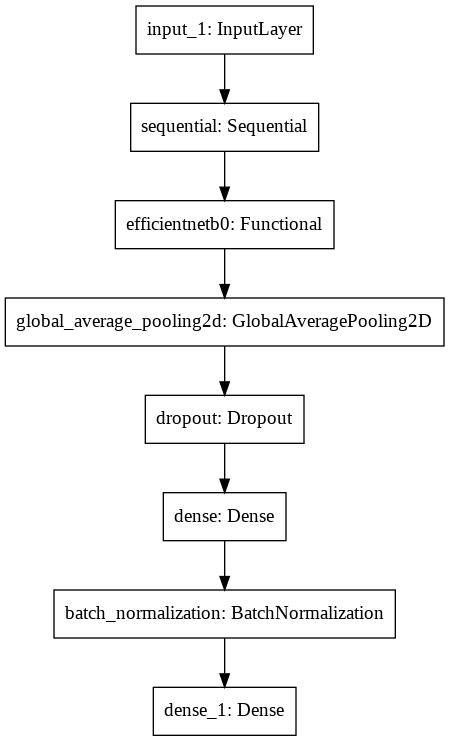

In [16]:
utils.plot_model(model)

***Create Callbacks***

In [17]:
                
#save_path = '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/model_checkpoints/efficientnet_models/'                   
save_path = '/content/drive/My Drive/Colab_Runs/'
save_name = "Mar20-checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5"     

checkpoint = ModelCheckpoint(save_path+save_name,
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1,
                             save_weights_only = False)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.001, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.8,
                              patience = 2,
                              verbose = 1,
                              min_delta = 0.0001,
                              min_lr = 0.00000001)


callbacks = [earlystop,reduce_lr,checkpoint,WandbCallback()]


***Compile the Model***

In [18]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=LR),
              metrics = ['accuracy'])

model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE[0],IMAGE_SIZE[1],3))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 360, 360, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 12, 12, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048  

In [19]:
# set hyperparameters

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

***Train the Model***

In [ ]:
history = model.fit(
    train_dataset,
    #class_weight = class_weights,
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = callbacks,
    verbose = 1,
    steps_per_epoch = STEPS_PER_EPOCH
    )


Epoch 1/100
1002/1002 [==============================] - 348s 321ms/step - loss: 4.6169 - accuracy: 0.6192 - val_loss: 45.6153 - val_accuracy: 0.6127

Epoch 00001: val_loss improved from inf to 45.61535, saving model to /content/drive/My Drive/Colab_Runs/Mar20-checkpoint-01-45.62.hdf5
Epoch 2/100
1002/1002 [==============================] - 312s 312ms/step - loss: 0.8766 - accuracy: 0.7679 - val_loss: 3.0553 - val_accuracy: 0.1291

Epoch 00002: val_loss improved from 45.61535 to 3.05527, saving model to /content/drive/My Drive/Colab_Runs/Mar20-checkpoint-02-3.06.hdf5
Epoch 3/100
1002/1002 [==============================] - 313s 312ms/step - loss: 0.7774 - accuracy: 0.7876 - val_loss: 1.9542 - val_accuracy: 0.1855

Epoch 00003: val_loss improved from 3.05527 to 1.95423, saving model to /content/drive/My Drive/Colab_Runs/Mar20-checkpoint-03-1.95.hdf5
Epoch 4/100
1002/1002 [==============================] - 315s 315ms/step - loss: 0.9037 - accuracy: 0.7518 - val_loss: 1.9062 - val_accurac

In [ ]:
# plot loss curves

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#wandb.config

In [ ]:
wandb.finish()

Helpful Notebooks:

splitting:

https://stackoverflow.com/questions/60704335/how-to-create-train-test-validation-split-of-tf-data-dataset-in-tf-2-1-0

shuffling, batchingm caching, prefetching:

https://www.kaggle.com/tt195361/splitting-tensorflow-dataset-for-validation

splitting, data collection:

https://www.kaggle.com/jsmithperera/cassava-inference


Extra Code Blocks:


In [ ]:
## Code investigating disproportionate weight classes

# import numpy as np
# import gc

# # create the iterator
# train_iter = iter(train_dataset)
# # # train_iter is taking all of the samples - trying to take just 100 samples
# # train_iter = iter(dataset_original.take(100))

# # define he accumulator
# class_occurrences = np.array([0,0,0,0,0])

# next_batch = train_iter.get_next_as_optional()
# while next_batch.has_value():
# # for _ in range(100):
#     # print(class_occurrences)
#     batch_labels = next_batch.get_value()[1]
#     batch_count = np.array(batch_labels).sum(axis=0)
#     class_occurrences = np.add(class_occurrences, batch_count)
#     # gc.collect()
#     next_batch = train_iter.get_next_as_optional()

# # use the class_occurrences to store the counts for each class:
# num_train = sum(class_occurrences)
# c0_cts = class_occurrences[0]
# c1_cts = class_occurrences[1]
# c2_cts = class_occurrences[2]
# c3_cts = class_occurrences[3]
# c4_cts = class_occurrences[4]


# # and use these to store the weights for the fit method:
# c0_weight = num_train/c0_cts
# c1_weight = num_train/c1_cts
# c2_weight = num_train/c2_cts
# c3_weight = num_train/c3_cts
# c4_weight = num_train/c4_cts

# class_weights = {0: c0_weight,
#                  1: c1_weight,
#                  2: c2_weight,
#                  3: c3_weight,
#                  4: c4_weight}

In [ ]:


# def addTopModelefficentB0(bottom_model, num_classes):
#     """creates the top or head of the model that will be 
#     placed ontop of the bottom layers"""
#     top_model = bottom_model.output
#     top_model = GlobalAveragePooling2D()(top_model)
#     top_model = Flatten() (top_model)
#     top_model = Dense(16, activation='relu') (top_model)
#     top_model = BatchNormalization()(top_model)
#     top_model = layers.GlobalAveragePooling2D()(top_model)
#     top_model = layers.Dropout(0.4)(top_model)
#     top_model = Dense(num_classes, activation="softmax")(top_model)
#     return top_model


## Code for a sequential model structure

# model = tf.keras.Sequential([
#     InputLayer(input_shape=(224,224,3)),              
#     # data_augmentation,
#     efficentB0,
#     GlobalAveragePooling2D(),
#     Dense(1024, kernel_regularizer='l2'),
#     BatchNormalization(),
#     Dropout(0.5),
    
#     Dense(512,kernel_regularizer='l2'),
#     BatchNormalization(),
#     Dropout(0.5),
    
#     Dense(128,kernel_regularizer='l2'),
#     BatchNormalization(),
#     Dropout(0.5),

#     Dense(32,kernel_regularizer='l2'),
#     BatchNormalization(),
#     Dropout(0.5),

#     #Dense(128,activation='relu'),
#     # naming the final layer before the softmax so we can use the pre-softmax
#     # output as our input to a kNN classifier
#     #Dense(32,activation='relu', name='embedding'),
#     Dense(classes,activation='softmax')
# ])

In [ ]:
# image_batch, label_batch = next(iter(dataset_original))

# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10, 10))
#     for n in range(25):
#         ax = plt.subplot(5, 5, n + 1)
#         plt.imshow(image_batch[n] / 255.0)
#         plt.title(f"{label_batch[n]}")
#         plt.axis("off")

# show_batch(image_batch.numpy(), label_batch.numpy())


# for raw_record in dataset_original.take(1):
#     example = tf.train.Example()
#     example.ParseFromString(raw_record)
#     print(example)

In [ ]:
#wandb.config
# can put choices about optimizer and learning reate in here
# gets stored on wandb website, instantiate anywhere
# whenever you do a run, it stores config associated with it

In [ ]:
#earlystop.get_monitor_value()


In [ ]:
#wandb.finish()

In [ ]:
#https://www.kaggle.com/frlemarchand/efficientnet-aug-tf-keras-for-cassava-diseases

In [ ]:
#https://www.kaggle.com/tuckerarrants/cassava-rapids-knn


In [ ]:
# import random

# seed = random.randint(1, 1000)


# base_model = EfficientNetB0(weights='imagenet',
#              # classifier_activation=None, 
#               include_top = False, 
#               input_shape = (224, 224, 3))
#               #classes=5)


# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # x = Dropout(rate = .2)(x)
# x = BatchNormalization()(x)
# x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
# # x = Dropout(rate = .2)(x)
# x = BatchNormalization()(x)
# predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# optimizer = Adam(lr=0.0001)
# # optimizer = RMSprop(lr=learning_rate)

# loss = "categorical_crossentropy"
# # loss = "kullback_leibler_divergence"

# for layer in model.layers:
#     layer.trainable = True
# # for layer in model.layers[-2:]:
# #     layer.trainable = True

# model.compile(optimizer=optimizer,
#               loss=loss,
#               metrics=["accuracy"])

# #model.summary()

# # First, split our train dataset into train and validation
# train_size = int((0.7 * 21397)/BATCH_SIZE) #<- hardcoded the number of training images for now
# val_size = int(21397/BATCH_SIZE) - train_size
# train_dataset = dataset_original.take(train_size).map(lambda x, y: (data_augmentation(x), y), 
#               num_parallel_calls=AUTOTUNE)
# val_dataset = dataset_original.take(val_size)

# # REMOVED THE DIVISION BY BATCH SIZE BECAUSE THAT HAPPENS ABOVE
# STEPS_PER_EPOCH = train_size
# VALIDATION_STEPS = val_size

In [ ]:
#***************

# def unfreeze_model(model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
#     model.compile(
#         optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
#     )
# unfreeze_model(model)

#model.build(input_shape=(BATCH_SIZE,224,224,3))
#model.summary()

#***************

In [ ]:
# from matplotlib import pyplot as plt


# def decode_image(image):
#   image = tf.image.decode_jpeg(image, channels=3)
#   image = tf.cast(image, tf.float32) / 255.0

#   image = tf.image.resize(image, [224,224])
#   image = tf.reshape(image, [*IMAGE_SIZE, 3])
#   return image


# # 
# def read_tfrecord(example, labeled):
#     tfrecord_format = {
#             "image": tf.io.FixedLenFeature([], tf.string),
#             "target": tf.io.FixedLenFeature([], tf.int64),
#         } if labeled else {
#             "image": tf.io.FixedLenFeature([], tf.string),
#             "image_name":tf.io.FixedLenFeature([], tf.string)
#             }
#     example = tf.io.parse_single_example(example, tfrecord_format)
#     image = decode_image(example["image"])
#     if labeled:
#         label = tf.cast(example["target"], tf.int32)
#        # label = tf.one_hot(label, 5)
#         return image, label
#     idnum = example['image_name']
#     return image, idnum

# def load_dataset(filenames, labeled=True, ordered=False):
#   ignore_order = tf.data.Options()
#   if not ordered:
#     ignore_order.experimental_deterministic = False  # disable order, increase speed
#   dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTOTUNE)
#   # automatically interleaves reads from multiple files
#   dataset = dataset.with_options(ignore_order)
#  # uses data as soon as it streams in, rather than in its original order
#   dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
#   # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
#   return dataset


# # def get_dataset(filenames, labeled=True):
# #   dataset = load_dataset(filenames, labeled=labeled)
# #   # dataset = dataset.take(1000)
# #   dataset = dataset.shuffle(100) #used to be 2048
# #   # rework the shuffle
# #   dataset = dataset.prefetch(buffer_size=AUTOTUNE)
# #   dataset = dataset.batch(BATCH_SIZE)
# #   return dataset

# def data_augment(image, lable):
#   return image, label

# # RECORD_PATH = tf.io.gfile.glob("train_tfrecords/*.tfrec")

# # dataset_original = get_dataset(RECORD_PATH)

In [ ]:
# # incorportating 2 learning rates


# from tensorflow.keras.optimizers import Adam
# from wandb.keras import WandbCallback
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
# # !pip install -q tensorflow_addons
# from tensorflow_addons.optimizers import MultiOptimizer


# # Learning Rate
# BASE_LR_INIT = 0.00001
# HEAD_LR_INIT = 0.001
# RAMPUP = 10
# EXP_DECAY = 0.1

# # Early Stopping
# MIN_DELTA_ES = 0.001
# PATIENCE_ES = 15

# # Reduce LR on Plateau
# FACTOR_RLR = 0.8
# PATIENCE_RLR = 3
# MIN_DELTA_RLR = 0.0001
# MIN_LR = 0.0000001

# RECORD_PATH = tf.io.gfile.glob("train_tfrecords/*.tfrec")
# # SAVE_PATH = '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/model_checkpoints/inception_models/'
# SAVE_PATH = '/content/drive/My Drive/Colab_Runs/'
# # SAVE_NAME = "March20-Resnet-checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5" 
# NAME_BASE = "March20-EfficientNet-checkpoint-"


# # checkpoint = ModelCheckpoint(SAVE_PATH+SAVE_NAME,
# #                              monitor = "val_loss",
# #                              mode = "min",
# #                              save_best_only = True,
# #                              save_weights_only = False,
# #                              verbose = 1)

# # CUSTOM CALLBACK TO SAVE CHECKPOINT WITHOUT OPTIMIZER

# class CheckpointNoOpt(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         model.save(filepath=SAVE_PATH+NAME_BASE+f"-{epoch}-.hdf5",
#                    overwrite=False,
#                    include_optimizer=False)
#         # print("End epoch {} of training; got log keys: {}".format(epoch, keys))
# checkpoint = CheckpointNoOpt()

# earlystop = EarlyStopping(monitor = 'val_loss', 
#                           min_delta = MIN_DELTA_ES, 
#                           patience = PATIENCE_ES,
#                           verbose = 1,
#                           restore_best_weights = True)

# # reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
# #                               factor = FACTOR_RLR,
# #                               patience = PATIENCE_RLR,
# #                               verbose = 1,
# #                               min_delta = MIN_DELTA_RLR,
# #                               min_lr = MIN_LR)

# def lr(epoch, start_lr, rampup_epochs, exp_decay):
#     if epoch < rampup_epochs:
#         return start_lr
#     else:
#         return start_lr * math.exp(-exp_decay * epoch)

# def schedule_base(epoch):
#     return lr(epoch, BASE_LR_INIT, RAMPUP, EXP_DECAY)

# def schedule_head(epoch): 
#     return lr(epoch, HEAD_LR_INIT, RAMPUP, EXP_DECAY)

# # scheduler_base = LearningRateScheduler(schedule_base, verbose=0)
# # scheduler_head = LearningRateScheduler(schedule_head, verbose=0) 

# learning_rate_base = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=BASE_LR_INIT, decay_steps=20, decay_rate=.1)
# learning_rate_head = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=HEAD_LR_INIT, decay_steps=20, decay_rate=.1)

# var_list_base = model.layers[0]
# var_list_head = model.layers[1:]
# opt_base = Adam(learning_rate=learning_rate_base)
# opt_head = Adam(learning_rate=learning_rate_head)

# optimizers_and_layers = [(opt_base, var_list_base),(opt_head, var_list_head)]
# opt = MultiOptimizer(optimizers_and_layers)


# # train_opt_base = opt_base.apply_gradients(zip(grads_base, var_list_base))
# # train_opt_head = opt_head.apply_gradients(zip(grads_head, var_list_head))
# # train_opt = tf.group(train_opt_base, train_opt_head)

# callbacks = [checkpoint,earlystop, wandb.keras.WandbCallback()]

# model.compile(loss = 'categorical_crossentropy',
#               optimizer = opt,
#               # optimizer = Adam(learning_rate=LR),
#               metrics = ['accuracy'])

# model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE[0],IMAGE_SIZE[1],3))
# model.summary()

